In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

In [2]:
#import libraries
import torch
import torch.nn as nn
from torch.autograd import Variable
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset

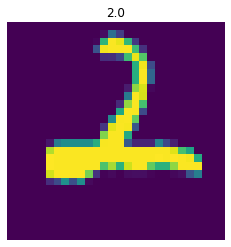

In [3]:
#prepare Dataset
#load data
train = pd.read_csv("train.csv", dtype = np.float32) # kaggle Digit Recognizer

#split data info features(pixels) and labels(numbers from 0 to 9)
targets_numpy = train.label.values
features_numpy = train.loc[:,train.columns != "label"].values/255 #normalization

#train test split. Size of train data is %80 and size of test data %20
features_train, features_test, targets_train, targets_test = train_test_split(features_numpy,
                                                                             targets_numpy,
                                                                             test_size = 0.2,
                                                                             random_state = 42)

#create feature and targets tensor for train set. As you remember we need variable to accumulate gradients. Therefore first 
#we create tensor,  then we will create variable
featuresTrain = torch.from_numpy(features_train)
targetsTrain = torch.from_numpy(targets_train).type(torch.LongTensor) # data type is long

#create feature and targets tensor for test set
featuresTest = torch.from_numpy(features_test)
targetsTest = torch.from_numpy(targets_test).type(torch.LongTensor) # data type is long

#batch_size, epoch and iteration
batch_size = 100
n_iters = 10000
num_epochs = n_iters / (len(features_train) / batch_size)
num_epochs = int(num_epochs)

#pytorch train and test sets
train = torch.utils.data.TensorDataset(featuresTrain,targetsTrain)
test = torch.utils.data.TensorDataset(featuresTest, targetsTest)

#data loader
train_loader = DataLoader(train, batch_size = batch_size, shuffle = False)
test_loader = DataLoader(test, batch_size = batch_size, shuffle = False)

#visualize one of the images in data set
plt.imshow(features_numpy[901].reshape(28,28))
plt.axis("off")
plt.title(str(targets_numpy[901]))
plt.savefig("graph.png")
plt.show()

In [6]:
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim):
        super(LSTMModel, self).__init__()
        
        #hidden dimensions
        self.hidden_dim = hidden_dim
        
        #number of hidden layers
        self.layer_dim = layer_dim
        
        #lstm
        self.lstm = nn.LSTM(input_dim, hidden_dim, layer_dim, batch_first = True) # batch_size=True (batch_dim, seq_dim, feature_dim)
        
        #readout layer
        self.fc = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, x):
        #initialize hidden state with zeros
        h0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).requires_grad_()
        
        #initialize cell state
        c0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).requires_grad_()
        
        #28 time steps
        # we need to detach as we are doing truncated backpropagation through time (BPTT)
        # if we don't. we'll backprop all the way to the start even after going through another batch
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))
        
        #index hidden state of last time step
        # out.size() -> 100, 28, 100
        # out[:, -1, :] --> 100, 100 --> just want last time step hidden states
        out = self.fc(out[:, -1, :])
        # out.size() --> 100, 10
        return out
    
input_dim = 28
hidden_dim = 100
layer_dim = 1
output_dim = 10
model = LSTMModel(input_dim, hidden_dim, layer_dim, output_dim)

error = nn.CrossEntropyLoss()

learning_rate = 0.1

optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate)

In [8]:
#number of steps to unroll
seq_dim = 28
loss_list = []
iteration_list = []
accuracy_list = []
count = 0
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        
        
        #load images as a torch tensor with gradient accumulation abilities
        images = images.view(-1, seq_dim, input_dim).requires_grad_()
        
        #clear gradients w.r.t. parameters
        optimizer.zero_grad()
        
        #forward pass to get output/logits
        outputs = model(images)
        
        #calculate softmax and ross entropy loss
        loss = error(outputs, labels)
        
        #calculating gradients
        loss.backward()
        
        #update parameters
        optimizer.step()
        
        count +=1
        
        if count % 500 == 0:
            #calculate accuracy
            correct = 0
            total = 0
            #iterate through test dataset
            for images, labels in test_loader:
                
                images = images.view(-1,seq_dim,input_dim)
                
                #forwardpass only to get logits/output
                outputs = model(images)
                
                #get predictions from the maximum 
                _, predicted = torch.max(outputs.data, 1)
                
                #total number of labels
                total += labels.size(0)
                
                correct += (predicted == labels).sum()
                
            accuracy = 100 * correct / float(total)
            
            #store loss and iteration
            loss_list.append(loss.data.item())
            iteration_list.append(count)
            accuracy_list.append(accuracy)
   
            #print loss
            print('Iteration: {}  Loss: {}  Accuracy: {} %'.format(count, loss.data, accuracy))     

Iteration: 500  Loss: 2.2595202922821045  Accuracy: 18.75 %
Iteration: 1000  Loss: 1.0387533903121948  Accuracy: 65.71428680419922 %
Iteration: 1500  Loss: 0.3361928164958954  Accuracy: 85.1547622680664 %
Iteration: 2000  Loss: 0.3204365074634552  Accuracy: 92.23809814453125 %
Iteration: 2500  Loss: 0.20592157542705536  Accuracy: 93.66666412353516 %
Iteration: 3000  Loss: 0.13645191490650177  Accuracy: 95.51190185546875 %
Iteration: 3500  Loss: 0.2635366916656494  Accuracy: 95.17857360839844 %
Iteration: 4000  Loss: 0.02001875638961792  Accuracy: 95.98809814453125 %
Iteration: 4500  Loss: 0.10544553399085999  Accuracy: 96.54762268066406 %
Iteration: 5000  Loss: 0.022960657253861427  Accuracy: 96.85713958740234 %
Iteration: 5500  Loss: 0.09606847167015076  Accuracy: 96.89286041259766 %
Iteration: 6000  Loss: 0.1230354979634285  Accuracy: 96.95237731933594 %
Iteration: 6500  Loss: 0.015563035383820534  Accuracy: 97.32142639160156 %
Iteration: 7000  Loss: 0.05643065273761749  Accuracy: 97

In [ ]:
#visualization loss
plt.plot(iteration_list,loss_list)
plt.xlabel("number of iteration")
plt.ylabel("loss")
plt.title("lstm: loss vs number of iteration")
plt.show()

#visualization accuracy
plt.plot(iteration_list,accuracy_list, color = "pink")
plt.xlabel("number of iteration")
plt.ylabel("accuracy")
plt.title("lstm: accuracy vs number of iteration")
plt.savefig("graph2.png")
plt.show()